<a href="https://colab.research.google.com/github/kd303/trnsfrmr_pytrch_end_p1/blob/main/pytorch_intro/PyTorchAssginment1_multitask_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement:

We are to solve for a neural network which outputs a sum of  an image of a number between **0 & 9** and also a *random number generated* between **0 & 9** 


Nueral nets are not great at solving linear equations, this is an excersize in understanding **PyTorch** Data Loader and built an intution on nural net and their working.

  
### **Following Image shows a sample of what we are trying to achieve:**
---
5 is an image and 7 is a generated number, which gives two outputs number that is recongnized by NN and 13 is a sum of two input numbers

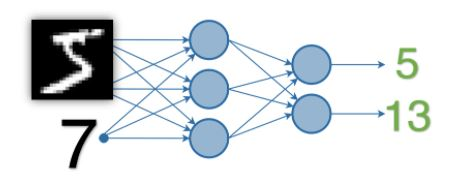


## Lets start with DataSet and Data Loader creation..

In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [3]:
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
import torch.nn as nn
from PIL import Image
import random as r
from typing import Any, Callable, Dict, List, Optional, Tuple
from torch.autograd import Variable

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
class MyDataset(MNIST):
  def __init__(
      self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    )-> None :
    super(MyDataset, self).__init__(root, transform=transform, 
                                    target_transform = target_transform,
                                    download = download,
                                    train = train)
   
  def __getitem__(self, index):
    
    img, target = self.data[index], int(self.targets[index])

    # doing this so that it is consistent with all other datasets
    # to return a PIL Image
    img = Image.fromarray(img.numpy(), mode='L')

    rand_input = r.randrange(0,9)

    rand_sum = rand_input + int(target)


    if self.transform is not None:
        img = self.transform(img)

    if self.target_transform is not None:
        target = self.target_transform(target)

    return img, target, rand_input, rand_sum

  def __len__(self):
    return len(self.data)

In [6]:
train_data = MyDataset(root = './data', 
               download=True, 
               transform = transforms.Compose([transforms.ToTensor()]),
               train = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MyDataset/raw/train-images-idx3-ubyte.gz to ./data/MyDataset/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MyDataset/raw/train-labels-idx1-ubyte.gz to ./data/MyDataset/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MyDataset/raw/t10k-images-idx3-ubyte.gz to ./data/MyDataset/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MyDataset/raw/t10k-labels-idx1-ubyte.gz to ./data/MyDataset/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


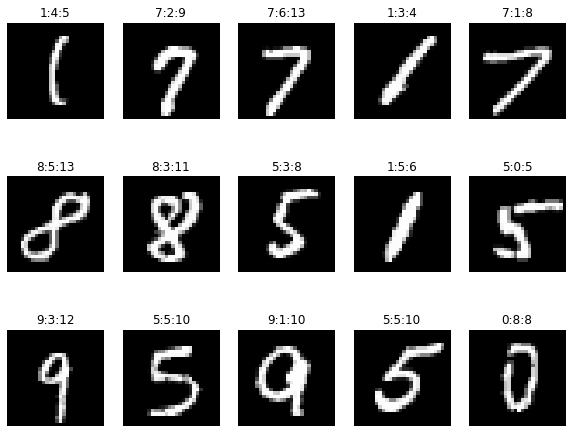

In [7]:
# Data visualization

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label, ran_input, ran_sum = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label) +':' + str(ran_input) + ':' + str(ran_sum))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
## This to create an input layer for converting the random inputs to one-hot encoded vectors, used
## as one of the processing layers, see the use of Variable
## courtsey : https://lirnli.wordpress.com/2017/09/03/one-hot-encoding-in-pytorch/

class One_Hot(nn.Module):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        self.ones = torch.sparse.torch.eye(depth)
        self.ones = self.ones.to(device)
    def forward(self, X_in):
        X_in = X_in.to(device)
        X_in = X_in.long()
        return Variable(self.ones.index_select(0,X_in.data))
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

## Lets Define the model 

We are looking something following logically

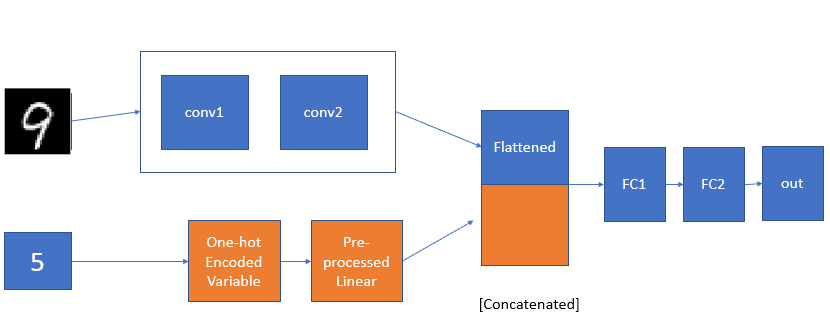

In [11]:
class CustomCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    self.fc1 = nn.Linear(in_features=212, out_features=212)
    self.fc2 = nn.Linear(in_features=212, out_features=100)
    self.out1 = nn.Linear(in_features=100, out_features=10)
    self.out2 = nn.Linear(in_features=100, out_features=19)
    self.preprocess_rand1 = nn.Linear(in_features = 10, out_features=20)
    self.one_hot_input = One_Hot(10)
  
  def forward(self, t):
    # input layer, t will have [image, img_label, ran_input, rand_sum]
    x = t[0]
    rand_input = t[2] 

    # print(x.shape, rand_input.shape, t[1].shape, t[3].shape)
    # conv1 layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

    # conv2 layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

    # reshape
    x = x.reshape(-1, 12 * 4 * 4)

    # preprocess the random input
    r_one_hot = self.one_hot_input(rand_input)
    y = self.preprocess_rand1(r_one_hot)    
    y = F.relu(y)

    # print(x.shape, y.shape)

    # Concate two inputs from Fc1 and rand_input
    x1 = torch.cat((x, y), dim=1)

    # print(x1.shape)
     # fc1 layer
    x1 = self.fc1(x1)
    x1 = F.relu(x1)

    # print('post fc1 ', x1.shape)
    # fc2 layer
    x1 = self.fc2(x1)
    x1 = F.relu(x1)
    # print('post fc2 ', x1.shape)
    # fc3 layer
    x_d = self.out1(x1)
    # print('post out ', x1.shape)
    x_d = F.softmax(x_d, dim=1)
    x_s = self.out2(x1)
    x_s = F.softmax(x_s, dim=1)
    return x_d, x_s

In [12]:
cnn = CustomCNN()
loss = nn.CrossEntropyLoss()

print(cnn)
print(loss)

cnn.to(device)



CustomCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=212, out_features=212, bias=True)
  (fc2): Linear(in_features=212, out_features=100, bias=True)
  (out1): Linear(in_features=100, out_features=10, bias=True)
  (out2): Linear(in_features=100, out_features=19, bias=True)
  (preprocess_rand1): Linear(in_features=10, out_features=20, bias=True)
  (one_hot_input): One_Hot(10)
)
CrossEntropyLoss()


CustomCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=212, out_features=212, bias=True)
  (fc2): Linear(in_features=212, out_features=100, bias=True)
  (out1): Linear(in_features=100, out_features=10, bias=True)
  (out2): Linear(in_features=100, out_features=19, bias=True)
  (preprocess_rand1): Linear(in_features=10, out_features=20, bias=True)
  (one_hot_input): One_Hot(10)
)

In [13]:
from torch import optim
import torch.nn.functional as F

optimizer = optim.Adam(cnn.parameters(), lr = 0.0001)


In [14]:
def get_num_correct(preds, labels):
  # print("preds.shape", preds.shape, "label.shape : ", labels.shape )
  # print("loss num", preds.argmax(dim=1).eq(labels).sum().item())
  return preds.argmax(dim=1).eq(labels).sum().item()

In [15]:
def get_num_correct_sum(preds, rand_sums):
  # print("preds.shape", preds.shape, "rand_sums : ", rand_sums.shape )
  # print("loss sum", preds.argmax(dim=1).eq(rand_sums).sum().item())  
  return preds.argmax(dim=1).eq(rand_sums).sum().item()

In [17]:
train_loader = torch.utils.data.DataLoader(train_data
    ,batch_size=64
    ,shuffle=True
)

In [18]:
def RMSELoss(yhat,y):
    # print(yhat.shape, y.shape)
    # print("label ", torch.argmax(yhat, dim=1).double()) # tensor.double()
    return torch.sqrt(torch.mean((torch.argmax(yhat, dim=1).double()-y)**2))

In [22]:
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)

for epoch in range(20):

    total_loss = 0
    total_correct_digits = 0
    total_correct_sum = 0

    for batch in train_loader: # Get Batch
        images, labels, rand_inputs, rand_sums = batch 
        # print(images.shape, labels.shape)
        images, labels, rand_inputs, rand_sums = images.to(device), labels.to(device), rand_inputs.to(device), rand_sums.to(device)
        preds_d, preds_s = cnn((images, labels, rand_inputs, rand_sums)) # Pass Batch
        
        
        # First 10 digits represents the predictions

        loss_mnist = F.cross_entropy(preds_d, labels)
        # last 19 digits represents the output
        loss_sum = F.cross_entropy(preds_s, rand_sums) 

        loss = (0.7*loss_mnist + 0.3*loss_sum)/2
        
        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct_digits += get_num_correct(preds_d, labels)
        total_correct_sum += get_num_correct_sum(preds_s, rand_sums)

    print(
        "epoch", epoch, 
        "total_correct_digits:", total_correct_digits, 
        "digit_pred_loss:", loss_mnist.item(), 
        "total_correct_sum:", total_correct_sum,
        "sum_pred_loss:", loss_sum.item(), 
         "loss:", total_loss
    )

epoch 0 total_correct_digits: 52503 digit_pred_loss: 1.537688136100769 total_correct_sum: 18173 sum_pred_loss: 2.7267262935638428 loss: 906.4720330834389
epoch 1 total_correct_digits: 57019 digit_pred_loss: 1.5231155157089233 total_correct_sum: 18671 sum_pred_loss: 2.755095958709717 loss: 881.3128862977028
epoch 2 total_correct_digits: 57979 digit_pred_loss: 1.4840041399002075 total_correct_sum: 18823 sum_pred_loss: 2.8227696418762207 loss: 874.9735544323921
epoch 3 total_correct_digits: 58095 digit_pred_loss: 1.5347189903259277 total_correct_sum: 19203 sum_pred_loss: 2.7243869304656982 loss: 873.1383193731308
epoch 4 total_correct_digits: 58246 digit_pred_loss: 1.4637491703033447 total_correct_sum: 19679 sum_pred_loss: 2.7790379524230957 loss: 871.0021443367004
epoch 5 total_correct_digits: 58323 digit_pred_loss: 1.470925211906433 total_correct_sum: 19978 sum_pred_loss: 2.592113494873047 loss: 869.6073899269104
epoch 6 total_correct_digits: 58420 digit_pred_loss: 1.4931182861328125 to

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.sparse.torch.eye(10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])